In [283]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import os
from itertools import cycle

# Import models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression


In [284]:

# Constants
RANDOM_STATE = 42
CV_SPLITS = 10

# Cell 2: Load Best Parameters and Create Models
def load_best_parameters():
    """Load best parameters from JSON file"""
    with open('storage_condition_results.json', 'r') as f:
        return json.load(f)

RESULTS_DIR = 'results/Storage_Condition_Classification_results'
os.makedirs(RESULTS_DIR, exist_ok=True)

def save_results(results_dict, filename):
    """Save results to JSON file in results directory"""
    filepath = os.path.join(RESULTS_DIR, filename)
    with open(filepath, 'w') as f:
        json.dump(results_dict, f, indent=4)
        
def create_models(best_params, scenario='with_product_type'):
    """Create models with best parameters"""
    models = {}
    params = best_params[scenario]
    
    for model_name, model_params in params.items():
        if model_name == 'SVM':
            models[model_name] = SVC(**model_params, random_state=42, probability=True)
        elif model_name == 'Random Forest':
            models[model_name] = RandomForestClassifier(**model_params, random_state=42)
        elif model_name == 'KNN':
            models[model_name] = KNeighborsClassifier(**model_params)
        elif model_name == 'Neural Network':
            models[model_name] = MLPClassifier(**model_params, random_state=42)
        elif model_name == 'Logistic Regression':
            models[model_name] = LogisticRegression(**model_params, random_state=42)
    
    return models


# Cell 3: Visualization Functions

In [285]:

# Cell 3: Visualization Functions
def plot_model_comparison(results_without, results_with):
    """Plot model comparison bar chart"""
    models = list(results_without.keys())
    
    means_without = [results_without[model]['mean_accuracy'] for model in models]
    stds_without = [results_without[model]['std_accuracy'] for model in models]
    
    means_with = [results_with[model]['mean_accuracy'] for model in models]
    stds_with = [results_with[model]['std_accuracy'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, means_without, width, yerr=stds_without,
                    label='Without Product Type', capsize=5)
    rects2 = ax.bar(x + width/2, means_with, width, yerr=stds_with,
                    label='With Product Type', capsize=5)
    
    ax.set_ylabel('Mean Accuracy')
    ax.set_title('Model Comparison for Storage Condition Classification')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'storage_condition_comparison.png'))
    plt.show()

In [286]:

def plot_confusion_matrices(results_without, results_with, class_labels):
    """Plot confusion matrices side by side for with/without product type"""
    for model_name in results_without.keys():
        # Create two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot first confusion matrix (Without Product Type)
        sns.heatmap(results_without[model_name]['confusion_matrix'], 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=range(len(class_labels)),
                   yticklabels=range(len(class_labels)), ax=ax1)
        ax1.set_title(f'{model_name} - Without Product Type')
        ax1.set_ylabel('Actual')
        ax1.set_xlabel('Predicted')
        
        # Plot second confusion matrix (With Product Type)
        sns.heatmap(results_with[model_name]['confusion_matrix'], 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=range(len(class_labels)),
                   yticklabels=range(len(class_labels)), ax=ax2)
        ax2.set_title(f'{model_name} - With Product Type')
        ax2.set_ylabel('Actual')
        ax2.set_xlabel('Predicted')
        
        plt.tight_layout()
        filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png'
        plt.savefig(os.path.join(RESULTS_DIR, filename))
        plt.close()
        


In [287]:
        
def plot_learning_curves(X, y, model, model_name, cv=CV_SPLITS):
    """Plot learning curves with confidence intervals"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    #cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=train_sizes,
        cv=cv,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.15, color='blue')
    plt.plot(train_sizes, val_mean, label='Cross-validation Score', color='red', marker='o')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.15, color='red')
    
    plt.title(f'Learning Curves - {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right')
    
    final_train = f"Final training score: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}"
    final_val = f"Final validation score: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}"
    plt.annotate(final_train, xy=(0.6, 0.2), xycoords='axes fraction')
    plt.annotate(final_val, xy=(0.6, 0.15), xycoords='axes fraction')
    
    plt.tight_layout()
    #plt.savefig(f'learning_curve_{model_name.lower().replace(" ", "_")}.png')
    #plt.show()
    # Save plot
    filename = f'learning_curve_{model_name.lower().replace(" ", "_")}.png'
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.close()
    
    return {
        'train_sizes': train_sizes,
        'train_scores': {'mean': train_mean, 'std': train_std},
        'val_scores': {'mean': val_mean, 'std': val_std}
    }

In [288]:

def perform_statistical_analysis(results_without, results_with):
    """Perform statistical analysis"""
    analysis_results = []
    
    print("\nStatistical Analysis Results:")
    print("="*50)
    
    for model in results_without.keys():
        acc_without = results_without[model]['fold_accuracies']
        acc_with = results_with[model]['fold_accuracies']
        
        t_stat, p_value = stats.ttest_rel(acc_with, acc_without)
        improvement = (np.mean(acc_with) - np.mean(acc_without)) * 100
        
        result = {
            'Model': model,
            'Accuracy without Product': f"{np.mean(acc_without):.4f} ± {np.std(acc_without):.4f}",
            'Accuracy with Product': f"{np.mean(acc_with):.4f} ± {np.std(acc_with):.4f}",
            'Improvement (%)': f"{improvement:.2f}%",
            'p-value': f"{p_value:.4f}",
            'Significant': "Yes" if p_value < 0.05 else "No"
        }
        analysis_results.append(result)
        
        print(f"\n{model}:")
        print(f"- Without Product Type: {result['Accuracy without Product']}")
        print(f"- With Product Type: {result['Accuracy with Product']}")
        print(f"- Improvement: {result['Improvement (%)']}")
        print(f"- Statistical Significance (p < 0.05): {result['Significant']} (p = {result['p-value']})")

    results_df = pd.DataFrame(analysis_results)
    results_df.to_csv('statistical_analysis_results.csv', index=False)
    return results_df
    


# Cell 4: Data Preparation

In [289]:

# Cell 4: Data Preparation
def prepare_data():
    """Load and prepare data consistently"""
    print("Loading data and preparing features...")
    data = pd.read_csv('augmented_bakery_data.csv')
    
    # Encode labels
    le_product = LabelEncoder()
    le_storage = LabelEncoder()
    data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])
    data['Storage_Condition_encoded'] = le_storage.fit_transform(data['Storage_Condition'])
    
    # Prepare features
    feature_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
    X_base = data[feature_cols]
    
    # Scale features on entire dataset
    scaler = StandardScaler()
    X_base_scaled = scaler.fit_transform(X_base)
    
    # Prepare datasets
    X_without_product = X_base_scaled
    X_with_product = np.column_stack([X_base_scaled, data['Product_Type_encoded'].values.reshape(-1, 1)])
    y_storage = data['Storage_Condition_encoded'].values
    
    return X_with_product, X_without_product, y_storage, le_storage.classes_


# Cell 5: Model Evaluation

In [290]:

# Cell 5: Model Evaluation
def evaluate_models(X, y, models, cv=CV_SPLITS):
    """Evaluate models using cross-validation"""
    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        fold_accuracies = []
        all_predictions = []
        all_true_labels = []
        
        for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            # Split data (already scaled)
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Fit and predict
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            acc = accuracy_score(y_test, y_pred)
            fold_accuracies.append(acc)
            all_predictions.extend(y_pred)
            all_true_labels.extend(y_test)
            
            print(f"Fold {fold_idx + 1} accuracy: {acc:.4f}")
        
        # Store results
        results[model_name] = {
            'fold_accuracies': np.array(fold_accuracies),
            'mean_accuracy': np.mean(fold_accuracies),
            'std_accuracy': np.std(fold_accuracies),
            'confusion_matrix': confusion_matrix(all_true_labels, all_predictions),
            'classification_report': classification_report(all_true_labels, all_predictions)
        }
        
        print(f"\n{model_name} Final Results:")
        print(f"Mean accuracy: {results[model_name]['mean_accuracy']:.4f} ± {results[model_name]['std_accuracy']:.4f}")
        print("\nClassification Report:")
        print(results[model_name]['classification_report'])
    
    return results

In [291]:
def save_analysis_summary(results_without, results_with, stats_results):
    """Generate and save comprehensive analysis summary"""
    
    with open('analysis_summary.txt', 'w') as f:
        # Header
        f.write("Storage Condition Classification Analysis Summary\n")
        f.write("==================================================\n\n")
        
        # 1. Best Performing Models section
        f.write("1. Best Performing Models:\n\n")
        
        # Find best models
        best_without = max(results_without.items(), 
                         key=lambda x: x[1]['mean_accuracy'])
        best_with = max(results_with.items(), 
                       key=lambda x: x[1]['mean_accuracy'])
        
        # Without Product Type
        f.write("Without Product Type:\n")
        f.write(f"- Best Model: {best_without[0]}\n")
        f.write(f"- Accuracy: {best_without[1]['mean_accuracy']:.4f} ± "
                f"{best_without[1]['std_accuracy']:.4f}\n\n")
        
        # With Product Type
        f.write("With Product Type:\n")
        f.write(f"- Best Model: {best_with[0]}\n")
        f.write(f"- Accuracy: {best_with[1]['mean_accuracy']:.4f} ± "
                f"{best_with[1]['std_accuracy']:.4f}\n\n")
        
        # 2. Impact of Product Type section
        f.write("2. Impact of Product Type:\n")
        
        # Create DataFrame for formatted table
        data = []
        for model_name in results_without.keys():
            acc_without = results_without[model_name]['mean_accuracy']
            std_without = results_without[model_name]['std_accuracy']
            
            acc_with = results_with[model_name]['mean_accuracy']
            std_with = results_with[model_name]['std_accuracy']
            
            improvement = ((acc_with - acc_without) / acc_without) * 100
            
            # Get p-value from stats_results DataFrame
            p_value = float(stats_results[stats_results['Model'] == model_name]['p-value'].values[0].strip())
            
            data.append({
                'Model': model_name,
                'Accuracy without Product': f"{acc_without:.4f} ± {std_without:.4f}",
                'Accuracy with Product': f"{acc_with:.4f} ± {std_with:.4f}",
                'Improvement (%)': f"{improvement:.2f}%",
                'p-value': f"{p_value:.4f}",
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        
        # Convert to DataFrame and write as formatted table
        df = pd.DataFrame(data)
        f.write(df.to_string(index=False))
        
        # Additional Analysis
        f.write("\n\n3. Additional Insights:\n")
        f.write("-----------------------\n")
        
        # Count models with significant improvement
        significant_improvements = sum(1 for d in data if float(d['Improvement (%)'].strip('%')) > 0 
                                    and d['Significant'] == 'Yes')
        f.write(f"\nNumber of models with significant improvement: {significant_improvements}\n")
        
        # Best improvement
        best_improvement = max(data, key=lambda x: float(x['Improvement (%)'].strip('%')))
        f.write(f"Model with best improvement: {best_improvement['Model']} "
                f"({best_improvement['Improvement (%)']})\n")
        
        # Overall recommendation
        f.write("\nOverall Recommendation:\n")
        if significant_improvements > 0:
            f.write("Including product type information appears beneficial for classification performance.\n")
        else:
            f.write("Product type information does not significantly improve classification performance.\n")

# # Cell 6: Main Execution

Loading data and preparing features...
Loading best parameters and creating models...

Evaluating models with product type...

Evaluating SVM...
Fold 1 accuracy: 0.9444
Fold 2 accuracy: 0.9444
Fold 3 accuracy: 0.7778
Fold 4 accuracy: 0.8333
Fold 5 accuracy: 1.0000
Fold 6 accuracy: 0.8889
Fold 7 accuracy: 0.7778
Fold 8 accuracy: 0.8333
Fold 9 accuracy: 1.0000
Fold 10 accuracy: 0.8889

SVM Final Results:
Mean accuracy: 0.8889 ± 0.0786

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        60
           1       0.96      0.92      0.94        60
           2       0.86      0.82      0.84        60

    accuracy                           0.89       180
   macro avg       0.89      0.89      0.89       180
weighted avg       0.89      0.89      0.89       180


Evaluating Random Forest...
Fold 1 accuracy: 0.9444
Fold 2 accuracy: 1.0000
Fold 3 accuracy: 1.0000
Fold 4 accuracy: 1.0000
Fold 5 accuracy: 1.0000
Fold 6 ac

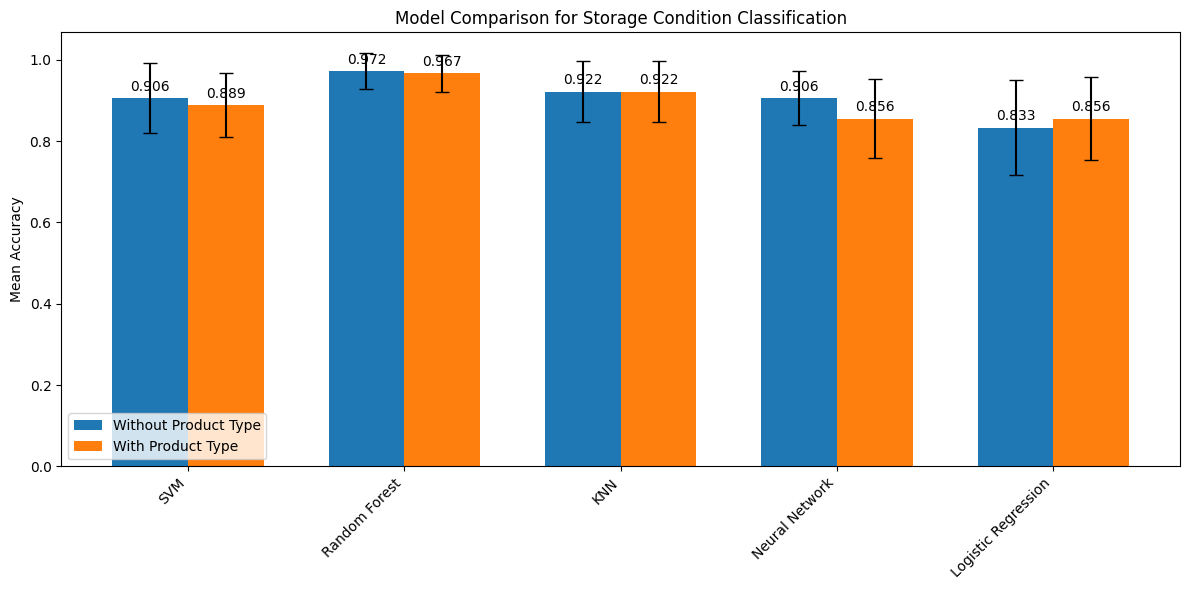


Statistical Analysis Results:

SVM:
- Without Product Type: 0.9056 ± 0.0862
- With Product Type: 0.8889 ± 0.0786
- Improvement: -1.67%
- Statistical Significance (p < 0.05): No (p = 0.5203)

Random Forest:
- Without Product Type: 0.9722 ± 0.0448
- With Product Type: 0.9667 ± 0.0444
- Improvement: -0.56%
- Statistical Significance (p < 0.05): No (p = 0.3434)

KNN:
- Without Product Type: 0.9222 ± 0.0754
- With Product Type: 0.9222 ± 0.0754
- Improvement: 0.00%
- Statistical Significance (p < 0.05): No (p = nan)

Neural Network:
- Without Product Type: 0.9056 ± 0.0660
- With Product Type: 0.8556 ± 0.0969
- Improvement: -5.00%
- Statistical Significance (p < 0.05): No (p = 0.0676)

Logistic Regression:
- Without Product Type: 0.8333 ± 0.1165
- With Product Type: 0.8556 ± 0.1030
- Improvement: 2.22%
- Statistical Significance (p < 0.05): No (p = 0.3434)

Generating learning curve for SVM...

Generating learning curve for Random Forest...

Generating learning curve for KNN...

Generating l

In [292]:
# # Cell 6: Main Execution
if __name__ == "__main__":
    # 1. Prepare Data
    X_with_product, X_without_product, y_storage, class_labels = prepare_data()
    
    # 2. Load Models
    print("Loading best parameters and creating models...")
    best_params = load_best_parameters()
    models_with_product = create_models(best_params, 'with_product_type')
    models_without_product = create_models(best_params, 'without_product_type')
    
    # 3. Evaluate Models
    print("\nEvaluating models with product type...")
    results_with_product = evaluate_models(X_with_product, y_storage, models_with_product)
    
    print("\nEvaluating models without product type...")
    results_without_product = evaluate_models(X_without_product, y_storage, models_without_product)
    
    # 4. Generate Visualizations and Analysis
    print("\nGenerating visualizations and analysis...")
    
    # Model comparison plot
    plot_model_comparison(results_without_product, results_with_product)
    
    # Confusion matrices
    plot_confusion_matrices(results_without_product, results_with_product, class_labels)
    
    # Statistical analysis
    stats_results = perform_statistical_analysis(results_without_product, results_with_product)
    
    # Save analysis summary
    save_analysis_summary(results_without_product, results_with_product, stats_results)

    # Learning curves
    for model_name, model in models_with_product.items():
        print(f"\nGenerating learning curve for {model_name}...")
        plot_learning_curves(X_with_product, y_storage, model, model_name)
    
    print("\nAnalysis complete!")